In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os

import matplotlib as mpl
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.size'] = 18

from matplotlib.gridspec import GridSpec

import sys
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/RingData/')

from DiffCorr import DiffCorr

In [75]:
def norm_w_mask(x,mask, threshold):
    x_out = np.zeros_like(x, dtype=np.float64)
    mask = mask.astype(bool)
    for ii in range(x.shape[0]):
        k=np.median(x[ii][mask[ii]])
        mu = np.std(x[ii][mask[ii]])
        this_mask = (np.abs(x[ii] - k)<mu*threshold)*mask[ii]
        
        shot_mean = x[ii][this_mask].mean()
#         x_out[ii] = (x[ii]-shot_mean)/shot_mean* this_mask
        x_out[ii] = (x[ii]-shot_mean)* this_mask
    return x_out

def diff_all_shots(images,mask,threshold):
    images = norm_all_shots(images, mask, threshold)
    diffs = images - images.mean(0)[None,:]
    
    return diffs, images

def norm_all_shots(images,mask, threshold):
    norms = np.zeros_like(images, dtype=np.float64)
    for ii in range(norms.shape[0]):
        norms[ii]=norm_w_mask(images[ii],mask, threshold)
    return norms


def normalize(d):
    x=d.copy()
    x-=x.min()
    return x/(x.max()-x.min())

def compute_asym(cor, phi_offset =15):
    cor_asym =[] 
    num_phi = cor.shape[-1]
    for ii ,cc in enumerate(cor):
        nc=normalize(cc[phi_offset:num_phi/2-phi_offset])
#         nc = cc.copy()
        cor_asym.append( (np.abs(nc-nc[::-1])).mean() )
    cor_asym=np.array(cor_asym)
    
    return cor_asym

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

def range_mask(img,min,max):
    return (img>min)*(img<max)
def donut_mask(mask,rmin,rmax):
    xx,yy=np.meshgrid(range(mask.shape[1]), range(mask.shape[0]))
    rr = np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    return (rr>rmin)*(rr<rmax)*mask


def draw_circle(ax, radius, center,color):
    circle1=plt.Circle(center,radius,color=color,
                       linewidth=3, fill=False,
                      linestyle='--',alpha=1)
    ax.add_artist(circle1)

In [38]:
file_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/combined_tables/gai/'
run=102
f=h5py.File(os.path.join(file_dir,'run%d.tbl'%run), 'r')
print f.keys()
pi = f['polar_imgs'][:3000]
rp = f['radial_profs'][:3000]
f.close()

cali_file_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/combined_tables/cali_gai/'
run=111
f=h5py.File(os.path.join(cali_file_dir,'run%d.tbl'%run), 'r')
print f.keys()
cali_pi = f['polar_imgs'][:3000]
pmask = f['polar_mask_binned'].value
pmask=(pmask==pmask.max())
f.close()

[u'ebeam', u'event_time', u'evr', u'fiducials', u'gas_detector', u'phase_cav', u'polar_imgs', u'polar_mask', u'polar_mask_binned', u'polar_params', u'radial_profs']
[u'ebeam', u'event_time', u'evr', u'fiducials', u'gas_detector', u'phase_cav', u'polar_imgs', u'polar_mask', u'polar_mask_binned', u'polar_params', u'radial_profs']


In [39]:
diff, norm_pi = diff_all_shots(pi.astype(np.float64),pmask,2.5)
cali_diff, norm_cali_pi=diff_all_shots(cali_pi.astype(np.float64),pmask,2.5)


-8.32416223243e-14 -1.55101283324e-13
8.48784602947e-13 6.45220628899e-13
-5.97517523084e-13 1.31324934667e-14
1.08473448877e-12 6.73991636987e-13


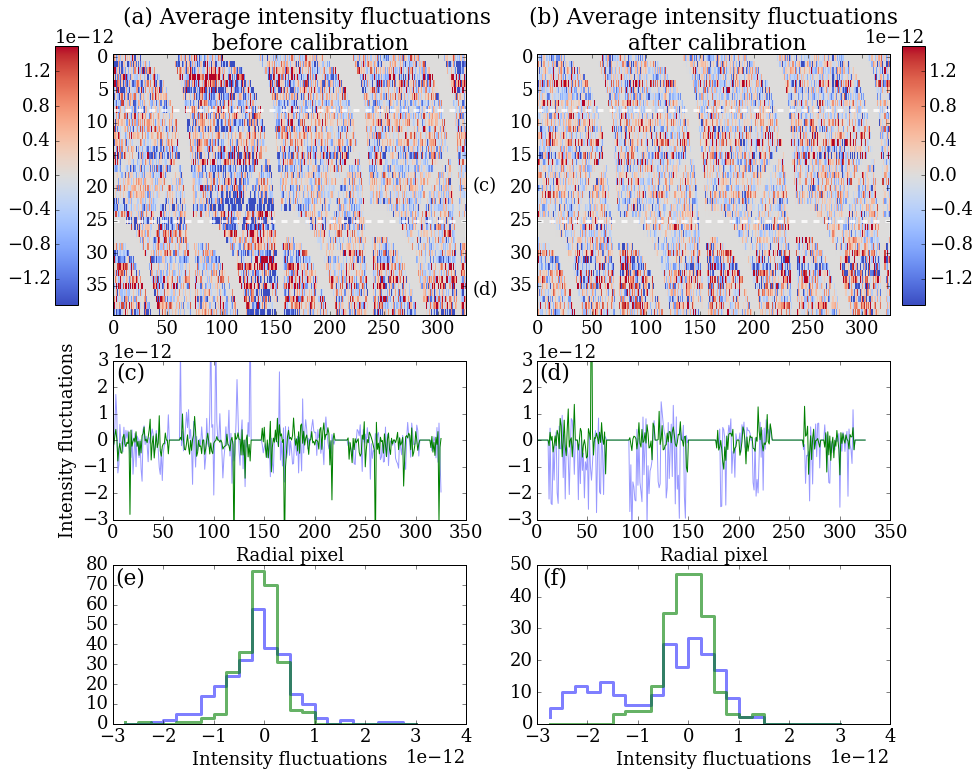

In [105]:
x=-1.5e-12
y=1.5e-12
qinds = [8,25]

fig = plt.figure(figsize=[16,12])
gs = GridSpec(7,2)
gs.update(hspace = 0.8)
######## two interpolated images before and after
ax = plt.subplot(gs[:3,0])
cutoff = 40
img = (diff.mean(0)*pmask)[0:cutoff]
im = plt.imshow( img, aspect='auto',
           vmin=x,vmax=y, cmap='coolwarm', interpolation='none')
plt.hlines(qinds,0,326, linewidth=3, linestyle='--', alpha = 0.8, color = 'w')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.075, 0.61, 0.02, 0.3])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')

ax.set_title('(a) Average intensity fluctuations\n before calibration'
             , x= 0.55,y =1, color='Black')
plt.text(s='(c)', x =18.1,y = 0.44)
plt.text(s='(d)', x =18.1,y = 0.04)
##### after calibration

ax = plt.subplot(gs[:3,1])
img = (cali_diff.mean(0)*pmask)[0:cutoff]
im = plt.imshow(img, aspect='auto'
          ,vmin=x,vmax=y, cmap='coolwarm', interpolation='none')
plt.hlines(qinds,0,326, linewidth=3, linestyle='--', alpha = 0.8, color = 'w')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.61, 0.02, 0.3])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('right')


ax.set_title('(b) Average intensity fluctuations\n after calibration'
             , x= 0.5,y =1, color='Black')

###################### individual slice of polar image
ax=plt.subplot(gs[3:5,0])
ax.set_title('(c)', x= 0.05,y =0.85, color='Black')
qidx = qinds[0]
plt.plot(diff.mean(0)[qidx],'b', alpha = 0.4)
plt.plot(cali_diff.mean(0)[qidx],'g')

plt.ylim(-3e-12,3e-12)
plt.xlabel('Radial pixel')
plt.ylabel('Intensity fluctuations')
##########################histogram that slice
ax=plt.subplot(gs[5:,0])
ax.set_title('(e)', x= 0.05,y =0.85, color='Black')
bins= np.linspace(-3e-12,3e-12,25)
x = diff.mean(0)[qidx][pmask[qidx]]
hist1=np.histogram(x,bins=bins)
y = cali_diff.mean(0)[qidx][pmask[qidx]]
hist2=np.histogram(y,bins=bins)

plt.step(bins[1:],hist1[0], color='b' , linewidth=3, alpha = 0.5)
plt.step(bins[1:],hist2[0], color='g', linewidth=3, alpha = 0.6 )

plt.xlabel('Count')
plt.xlabel('Intensity fluctuations')

print x.mean(), y.mean()
print x.std(), y.std()

###################### individual slice of polar image
ax = plt.subplot(gs[3:5,1])
ax.set_title('(d)', x= 0.05,y =0.85, color='Black')
qidx = qinds[1]
plt.plot(diff.mean(0)[qidx],'b', alpha = 0.4)
plt.plot(cali_diff.mean(0)[qidx],'g')
plt.xlabel('Radial pixel')
plt.ylim(-3e-12,3e-12)
#################### histogram that slice

ax=plt.subplot(gs[5:,1])
ax.set_title('(f)', x= 0.05,y =0.85, color='Black')
x = diff.mean(0)[qidx][pmask[qidx]]
hist1=np.histogram(x,bins=bins)
y = cali_diff.mean(0)[qidx][pmask[qidx]]
hist2=np.histogram(y,bins=bins)

plt.step(bins[1:],hist1[0], color='b', linewidth=3, alpha = 0.5 )
plt.step(bins[1:],hist2[0], color='g', linewidth=3, alpha = 0.6 )
plt.xlabel('Intensity fluctuations')
print x.mean(), y.mean()
print x.std(), y.std()

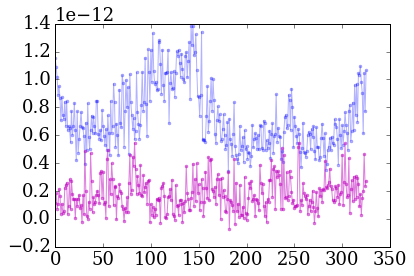

In [41]:
qrange = range(0,40)

dd=pmask[qrange].sum(0)
dd[dd==0]=1
mean_diff =np.abs(diff.mean(0))[qrange].sum(0)/dd
cali_mean_diff = np.abs(cali_diff.mean(0))[qrange].sum(0)/dd
plt.plot(mean_diff,'.-',alpha=0.3, c='b')
plt.plot(cali_mean_diff-4e-13, '.-',alpha=0.5, c='m')
# plt.ylim(-0.01,0.01)

In [49]:
mask=np.load('/reg/d/psdm/cxi/cxilr6716/results/masks/basic_psana_mask.npy')
polar_correct = np.load('/reg/d/psdm/cxi/cxilr6716/scratch/derm/polarization_-400encode.npy')
center=np.load('/reg/d/psdm/cxi/cxilr6716/scratch/derm/center_-400encoder.npy')

run= 109
file_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/'
f_imgs=h5py.File(os.path.join(file_dir,'fullImgs_run%d.h5'%run), 'r')
single_shots = f_imgs['flat_img'][:300]
single_shots_int = single_shots.mean(-1)
selection_mask = (single_shots_int>1.3)*(single_shots_int<95.7)
single_shots=single_shots[selection_mask]
single_shots= (unflatten_shots( single_shots, mask)/polar_correct[None,:,:]).mean(0)


In [79]:
12/7.*2

3.4285714285714284

-8.32416223243e-14 -1.55101283324e-13
8.48784602947e-13 6.45220628899e-13
-5.97517523084e-13 1.31324934667e-14
1.08473448877e-12 6.73991636987e-13


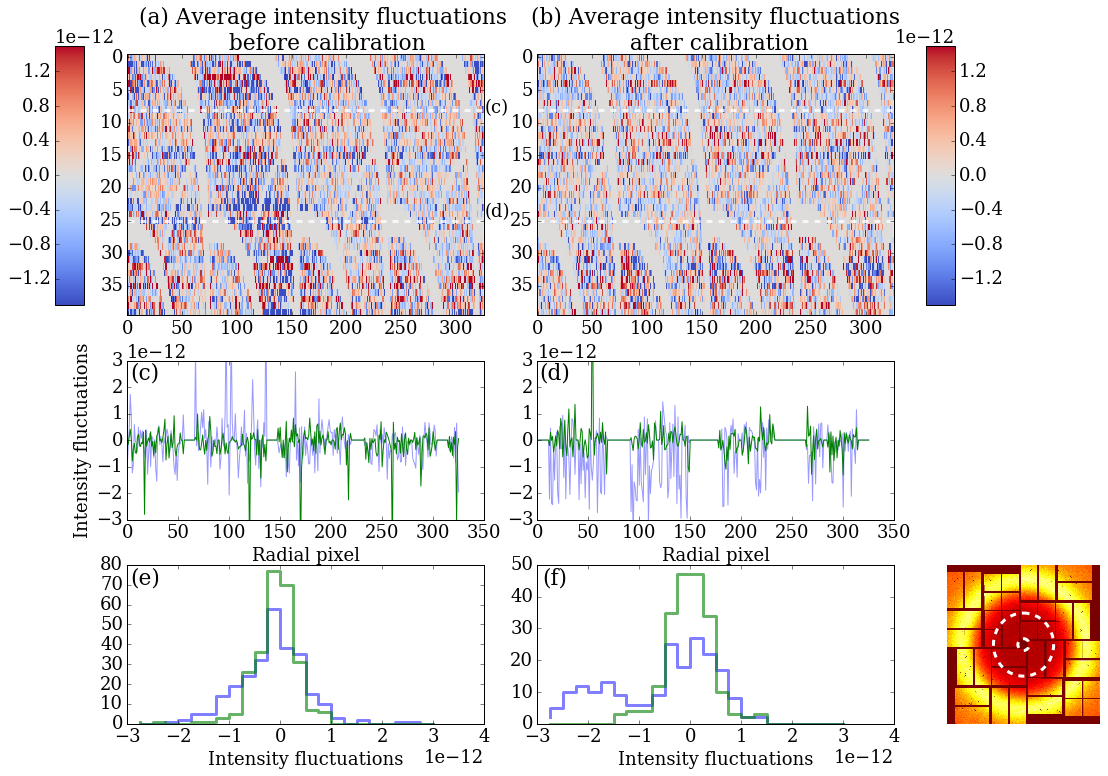

In [113]:
x=-1.5e-12
y=1.5e-12
qinds = [8,25]

fig = plt.figure(figsize=[20,12])
gs = GridSpec(7,5)
gs.update(hspace = 0.8, wspace = 0.35)
######## two interpolated images before and after
ax = plt.subplot(gs[:3,:2])
cutoff = 40
img = (diff.mean(0)*pmask)[0:cutoff]
im = plt.imshow( img, aspect='auto',
           vmin=x,vmax=y, cmap='coolwarm', interpolation='none')
plt.hlines(qinds,0,326, linewidth=3, linestyle='--', alpha = 0.8, color = 'w')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.075, 0.61, 0.02, 0.3])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')

ax.set_title('(a) Average intensity fluctuations\n before calibration'
             , x= 0.55,y =1, color='Black')
plt.text(s='(c)', x =14.9,y = 0.74)
plt.text(s='(d)', x =14.9,y = 0.34)
##### after calibration

ax = plt.subplot(gs[:3,2:4])
img = (cali_diff.mean(0)*pmask)[0:cutoff]
im = plt.imshow(img, aspect='auto'
          ,vmin=x,vmax=y, cmap='coolwarm', interpolation='none')
plt.hlines(qinds,0,326, linewidth=3, linestyle='--', alpha = 0.8, color = 'w')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.68, 0.61, 0.02, 0.3])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('right')


ax.set_title('(b) Average intensity fluctuations\n after calibration'
             , x= 0.5,y =1, color='Black')

###################### individual slice of polar image
ax=plt.subplot(gs[3:5,:2])
ax.set_title('(c)', x= 0.05,y =0.85, color='Black')
qidx = qinds[0]
plt.plot(diff.mean(0)[qidx],'b', alpha = 0.4)
plt.plot(cali_diff.mean(0)[qidx],'g')

plt.ylim(-3e-12,3e-12)
plt.xlabel('Radial pixel')
plt.ylabel('Intensity fluctuations')
##########################histogram that slice
ax=plt.subplot(gs[5:,:2])
ax.set_title('(e)', x= 0.05,y =0.85, color='Black')
bins= np.linspace(-3e-12,3e-12,25)
x = diff.mean(0)[qidx][pmask[qidx]]
hist1=np.histogram(x,bins=bins)
y = cali_diff.mean(0)[qidx][pmask[qidx]]
hist2=np.histogram(y,bins=bins)

plt.step(bins[1:],hist1[0], color='b' , linewidth=3, alpha = 0.5)
plt.step(bins[1:],hist2[0], color='g', linewidth=3, alpha = 0.6 )

plt.xlabel('Count')
plt.xlabel('Intensity fluctuations')

print x.mean(), y.mean()
print x.std(), y.std()

###################### individual slice of polar image
ax = plt.subplot(gs[3:5,2:4])
ax.set_title('(d)', x= 0.05,y =0.85, color='Black')
qidx = qinds[1]
plt.plot(diff.mean(0)[qidx],'b', alpha = 0.4)
plt.plot(cali_diff.mean(0)[qidx],'g')
plt.xlabel('Radial pixel')
plt.ylim(-3e-12,3e-12)
#################### histogram that slice

ax=plt.subplot(gs[5:,2:4])
ax.set_title('(f)', x= 0.05,y =0.85, color='Black')
x = diff.mean(0)[qidx][pmask[qidx]]
hist1=np.histogram(x,bins=bins)
y = cali_diff.mean(0)[qidx][pmask[qidx]]
hist2=np.histogram(y,bins=bins)

plt.step(bins[1:],hist1[0], color='b', linewidth=3, alpha = 0.5 )
plt.step(bins[1:],hist2[0], color='g', linewidth=3, alpha = 0.6 )
plt.xlabel('Intensity fluctuations')
print x.mean(), y.mean()
print x.std(), y.std()

# plt.figure(figsize=[12,12])
# gs = GridSpec(1,1)

#################### inset showing where the polar images are taken from
ax=plt.subplot(gs[5:7,4:] )
x=-10
y=50
plt.imshow(single_shots,aspect='auto',
          cmap='hot',vmin=x,vmax=y)
draw_circle(ax,65,center,'w')
draw_circle(ax,415-10*7,center,'w')
ax.set_axis_off()

# plt.savefig('polar_imgs_calibrated.png',bbox_in_inches='tight')

In [42]:
qs = np.linspace(0,1.0,diff.shape[1])
dc = DiffCorr(pmask[None,:], qs, 0, pre_dif=True)
mask_cor = dc.autocorr()

dc = DiffCorr(diff, qs, 0, pre_dif=True)
cor = dc.autocorr()/mask_cor

dc = DiffCorr(cali_diff, qs, 0, pre_dif=True)
cali_cor = dc.autocorr()/mask_cor

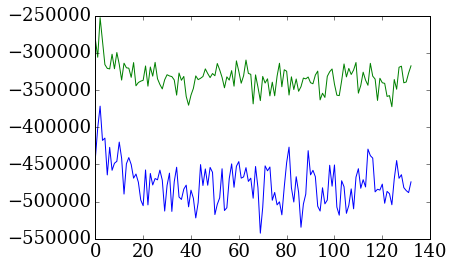

In [46]:
num_phi = diff.shape[-1]
phi_offset = 15
qidx= 29
plt.plot(cor.mean(0).mean(0)[phi_offset:num_phi/2-phi_offset]) 
plt.plot(cali_cor.mean(0).mean(0)[phi_offset:num_phi/2-phi_offset]) 

# plt.plot(normalize(cor.mean(0)[qidx, phi_offset:num_phi/2-phi_offset]) )
# plt.plot(normalize(cali_cor.mean(0)[qidx, phi_offset:num_phi/2-phi_offset]) )

In [44]:
phi_offset=2
cali_asym = compute_asym(cali_cor.mean(0), phi_offset=phi_offset)
asym = compute_asym(cor.mean(0), phi_offset=phi_offset)

0.211990991638 0.210434141852


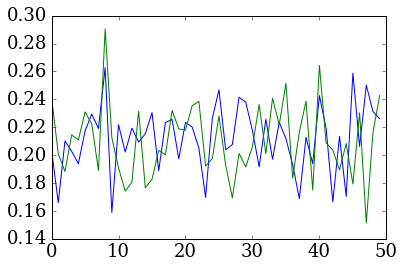

In [45]:
plt.plot(cali_asym)
plt.plot(asym)
print cali_asym.mean(), asym.mean()

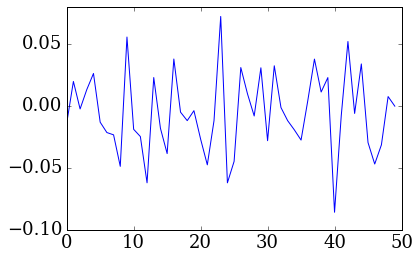

In [12]:
plt.plot(asym-cali_asym)

In [13]:
((asym-cali_asym)>0).sum()

18

In [14]:
asym.shape

(50,)